In [73]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [74]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [75]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 21, 10, 36, 59, 130972)

In [76]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-21 10:36:59,163 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-01-21 10:36:59,192 INFO: Initializing external client
2025-01-21 10:36:59,193 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-01-21 10:37:00,765 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [77]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION = STATION.replace(" ", "_")

In [78]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [79]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bike_availability_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [80]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

In [81]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.50s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-01-26 02:00:00+00:00,1.10,-2.710493,0.0,0.0,12.287555,31026.716797,4.900001,dublin,1,6,2
1,2025-01-22 17:00:00+00:00,4.50,1.923331,0.0,0.0,7.200000,30252.697266,3.300000,dublin,1,2,17
2,2025-01-23 19:00:00+00:00,3.55,-1.627320,0.0,0.0,19.694992,30442.521484,4.800000,dublin,1,3,19
3,2025-01-29 21:00:00+00:00,3.60,-2.222000,0.1,0.0,26.613230,31637.470703,9.500001,dublin,1,2,21
4,2025-01-21 12:00:00+00:00,7.15,4.392019,0.0,0.0,11.720751,30065.742188,0.000000,dublin,1,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...
223,2025-01-30 14:00:00+00:00,6.95,2.704199,0.0,0.0,15.913465,31849.486328,1.300000,dublin,1,3,14
224,2025-01-30 18:00:00+00:00,6.40,2.012719,0.0,0.0,17.208603,31849.486328,1.300000,dublin,1,3,18
225,2025-01-30 20:00:00+00:00,6.85,2.250813,0.0,0.0,19.645580,31849.486328,1.300000,dublin,1,3,20
226,2025-01-30 21:00:00+00:00,7.15,2.459609,0.0,0.0,20.870687,31849.486328,1.300000,dublin,1,3,21


## Creating predictions

In [82]:
batch_data['predicted_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['predicted_bikes_available'] = batch_data['predicted_bikes_available'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available
0,2025-01-26 02:00:00+00:00,1.10,-2.710493,0.0,0.0,12.287555,31026.716797,4.900001,dublin,1,6,2,33
1,2025-01-22 17:00:00+00:00,4.50,1.923331,0.0,0.0,7.200000,30252.697266,3.300000,dublin,1,2,17,14
2,2025-01-23 19:00:00+00:00,3.55,-1.627320,0.0,0.0,19.694992,30442.521484,4.800000,dublin,1,3,19,40
3,2025-01-29 21:00:00+00:00,3.60,-2.222000,0.1,0.0,26.613230,31637.470703,9.500001,dublin,1,2,21,41
4,2025-01-21 12:00:00+00:00,7.15,4.392019,0.0,0.0,11.720751,30065.742188,0.000000,dublin,1,1,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,2025-01-30 14:00:00+00:00,6.95,2.704199,0.0,0.0,15.913465,31849.486328,1.300000,dublin,1,3,14,2
224,2025-01-30 18:00:00+00:00,6.40,2.012719,0.0,0.0,17.208603,31849.486328,1.300000,dublin,1,3,18,33
225,2025-01-30 20:00:00+00:00,6.85,2.250813,0.0,0.0,19.645580,31849.486328,1.300000,dublin,1,3,20,37
226,2025-01-30 21:00:00+00:00,7.15,2.459609,0.0,0.0,20.870687,31849.486328,1.300000,dublin,1,3,21,37


In [83]:
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
4,2025-01-21 12:00:00+00:00,7.15,4.392019,0.0,0.0,11.720751,30065.742188,0.0,dublin,1,1,12,1,1
155,2025-01-21 13:00:00+00:00,7.70,4.933541,0.0,0.0,11.367109,30065.742188,0.0,dublin,1,1,13,0,2
60,2025-01-21 14:00:00+00:00,8.15,5.344414,0.0,0.0,11.013882,30065.742188,0.0,dublin,1,1,14,1,3
100,2025-01-21 15:00:00+00:00,8.10,5.350829,0.0,0.0,10.041354,30065.742188,0.0,dublin,1,1,15,1,4
138,2025-01-21 16:00:00+00:00,7.00,4.323315,0.0,0.0,9.028754,30065.742188,0.0,dublin,1,1,16,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2025-01-30 19:00:00+00:00,6.55,2.031153,0.0,0.0,18.511143,31849.486328,1.3,dublin,1,3,19,36,224
225,2025-01-30 20:00:00+00:00,6.85,2.250813,0.0,0.0,19.645580,31849.486328,1.3,dublin,1,3,20,37,225
226,2025-01-30 21:00:00+00:00,7.15,2.459609,0.0,0.0,20.870687,31849.486328,1.3,dublin,1,3,21,37,226
219,2025-01-30 22:00:00+00:00,7.45,2.669605,0.0,0.0,22.104116,31849.486328,1.3,dublin,1,3,22,38,227


## Create forecast graph

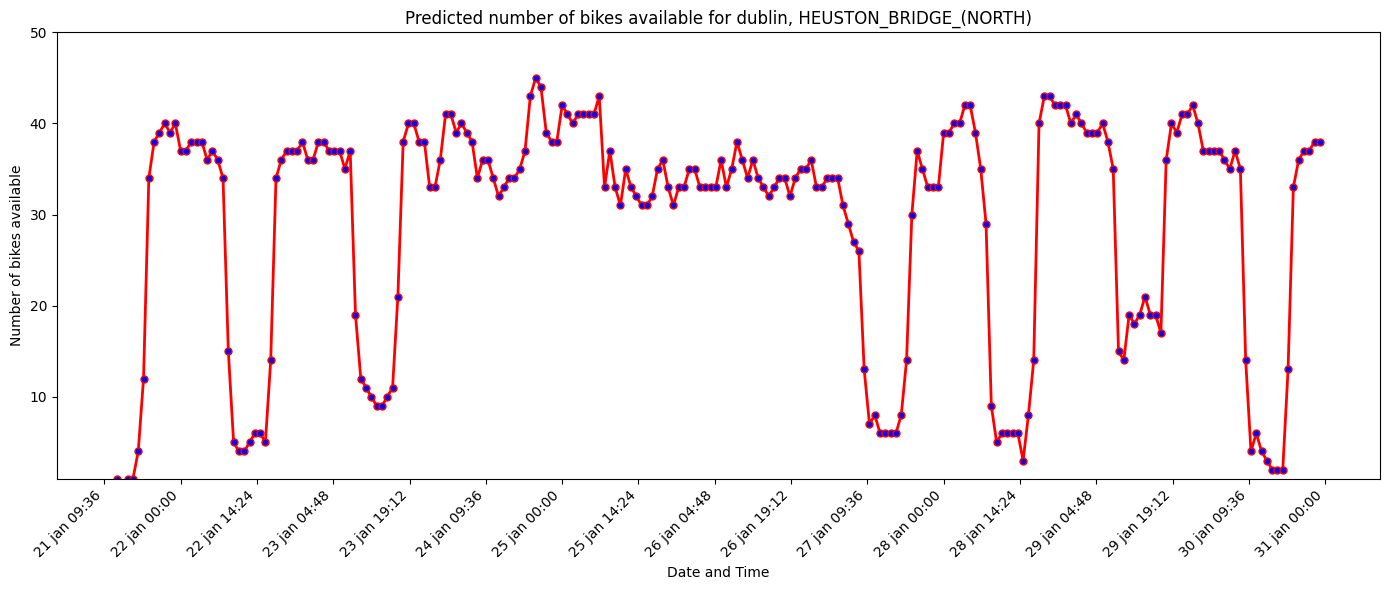

In [84]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, batch_data, file_path)
plt.show()

In [85]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bike_availability_predictions',
    description='Bike availability prediction monitoring for ' + STATION.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [86]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 100.00% |██████████| Rows 228/228 | Elapsed Time: 00:00 | Remaining Time: 00:00


Launching job: bike_availability_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions
2025-01-21 10:37:26,728 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-01-21 10:37:29,908 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-01-21 10:39:00,116 INFO: Waiting for log aggregation to finish.
2025-01-21 10:42:57,024 INFO: Execution finished successfully.


(Job('bike_availability_predictions_1_offline_fg_materialization', 'SPARK'),
 None)

In [87]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time <= 24).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
0,2025-01-20 12:00:00+00:00,8.6000,7.052317,0.1,0.0,6.763786,29881.912109,1.8,dublin,1,0,12,5,1
1,2025-01-21 04:00:00+00:00,5.4500,2.785907,0.0,0.0,10.365251,30065.742188,0.0,dublin,1,1,4,29,17
2,2025-01-21 03:00:00+00:00,5.5000,2.913811,0.0,0.0,9.904906,30065.742188,0.0,dublin,1,1,3,30,16
3,2025-01-22 06:00:00+00:00,2.2500,-0.657853,0.0,0.0,7.754637,30252.697266,3.3,dublin,1,2,6,37,19
4,2025-01-22 05:00:00+00:00,2.1000,-0.883082,0.0,0.0,8.089993,30252.697266,3.3,dublin,1,2,5,36,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,2024-12-29 12:00:00+00:00,10.0895,6.403931,0.0,0.0,21.675617,27249.105469,0.0,dublin,12,6,12,30,21
68,2024-12-29 00:00:00+00:00,7.9395,5.065456,0.0,0.0,13.619471,27249.105469,0.0,dublin,12,6,0,35,9
69,2024-12-28 17:00:00+00:00,8.7895,5.991804,0.0,0.0,15.070633,27194.826172,0.0,dublin,12,5,17,31,2
70,2024-12-29 05:00:00+00:00,6.4395,2.621438,0.0,0.0,18.329973,27249.105469,0.0,dublin,12,6,5,35,14


In [88]:
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
bike_df = bike_fg.read()

bike_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.30s) 


,datetime,station,num_bikes_available
0,2024-09-23 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),2.0
1,2023-10-07 13:00:00+00:00,HEUSTON_BRIDGE_(NORTH),29.0
2,2023-11-27 07:00:00+00:00,HEUSTON_BRIDGE_(NORTH),34.0
3,2024-01-22 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),35.0
4,2023-10-16 02:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
...,...,...,...
9569,2025-01-20 19:49:03+00:00,HEUSTON_BRIDGE_(NORTH),40.0
9570,2025-01-20 04:49:07+00:00,HEUSTON_BRIDGE_(NORTH),34.0
9571,2025-01-20 15:49:03+00:00,HEUSTON_BRIDGE_(NORTH),6.0
9572,2025-01-20 18:48:56+00:00,HEUSTON_BRIDGE_(NORTH),40.0


In [89]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.57s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,2024-11-17 07:00:00+00:00,6.6395,3.542508,0.0,0.0,13.091829,30647.093750,2.6,dublin
1,2024-07-26 02:00:00+00:00,12.0395,9.959105,0.0,0.0,15.349684,57427.019531,0.9,dublin
2,2024-08-02 09:00:00+00:00,18.9895,18.108223,0.0,0.0,19.469975,56053.718750,2.5,dublin
3,2024-03-28 18:00:00+00:00,8.1395,6.004910,0.1,0.0,4.334974,46005.636719,1.3,dublin
4,2024-01-09 08:00:00+00:00,3.7895,-1.855704,0.0,0.0,21.602999,28177.490234,0.0,dublin
...,...,...,...,...,...,...,...,...,...
13003,2025-01-30 14:00:00+00:00,6.9500,2.704199,0.0,0.0,15.913465,31849.486328,1.3,dublin
13004,2025-01-30 18:00:00+00:00,6.4000,2.012719,0.0,0.0,17.208603,31849.486328,1.3,dublin
13005,2025-01-30 20:00:00+00:00,6.8500,2.250813,0.0,0.0,19.645580,31849.486328,1.3,dublin
13006,2025-01-30 21:00:00+00:00,7.1500,2.459609,0.0,0.0,20.870687,31849.486328,1.3,dublin


In [90]:
def backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, model):
    features_df = weather_fg.read()

    features_df["month"] = features_df["datetime"].dt.month
    features_df["weekday"] = features_df["datetime"].dt.weekday  # 0=Monday, 6=Sunday
    features_df["hour"] = features_df["datetime"].dt.hour

    features_df = pd.merge(features_df, bike_df[['datetime','num_bikes_available']], on="datetime")
    features_df = features_df.sort_values(by=['datetime'], ascending=True)
    features_df = features_df.tail(10*24)
    
    features_df['predicted_bikes_available'] = model.predict(features_df[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']])
    features_df['predicted_bikes_available'] = features_df['predicted_bikes_available'].apply(lambda x: round(x))

    features_df['hours_before_forecast_time'] = range(1, len(features_df) + 1)
    hindcast_df = features_df
    features_df = features_df.drop('num_bikes_available', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    return hindcast_df

In [91]:
outcome_df = bike_df[['datetime', 'num_bikes_available']]
preds_df =  monitoring_df[['datetime', 'predicted_bikes_available']]

hindcast_df = pd.merge(preds_df, outcome_df, on="datetime")
hindcast_df = hindcast_df.sort_values(by=['datetime'])
print(len(hindcast_df))
hindcast_df

24


,datetime,predicted_bikes_available,num_bikes_available
11,2024-12-28 16:00:00+00:00,32,34.0
21,2024-12-28 17:00:00+00:00,31,33.0
6,2024-12-28 18:00:00+00:00,32,34.0
17,2024-12-28 19:00:00+00:00,32,33.0
7,2024-12-28 20:00:00+00:00,32,34.0
10,2024-12-28 21:00:00+00:00,36,34.0
16,2024-12-28 22:00:00+00:00,34,34.0
4,2024-12-28 23:00:00+00:00,34,35.0
20,2024-12-29 00:00:00+00:00,35,35.0
2,2024-12-29 01:00:00+00:00,35,35.0


In [92]:
outcome_df = outcome_df.sort_values(by=['datetime'])
outcome_df

,datetime,num_bikes_available
5695,2023-08-07 02:00:00+00:00,10.0
2161,2023-08-07 03:00:00+00:00,10.0
3422,2023-08-07 04:00:00+00:00,10.0
8312,2023-08-07 05:00:00+00:00,10.0
2192,2023-08-07 06:00:00+00:00,10.0
...,...,...
9569,2025-01-20 19:49:03+00:00,40.0
9567,2025-01-20 20:49:08+00:00,40.0
9568,2025-01-20 21:49:09+00:00,40.0
9552,2025-01-20 22:49:02+00:00,40.0


In [93]:
preds_df = preds_df.sort_values(by=['datetime'])
preds_df

,datetime,predicted_bikes_available
59,2024-12-28 16:00:00+00:00,32
69,2024-12-28 17:00:00+00:00,31
54,2024-12-28 18:00:00+00:00,32
65,2024-12-28 19:00:00+00:00,32
55,2024-12-28 20:00:00+00:00,32
...,...,...
34,2025-01-22 07:00:00+00:00,36
29,2025-01-22 08:00:00+00:00,34
16,2025-01-22 09:00:00+00:00,15
13,2025-01-22 10:00:00+00:00,5


In [94]:

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
print("Hindcast length: ", len(hindcast_df))
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Hindcast length:  24


,datetime,predicted_bikes_available,num_bikes_available
11,2024-12-28 16:00:00+00:00,32,34.0
21,2024-12-28 17:00:00+00:00,31,33.0
6,2024-12-28 18:00:00+00:00,32,34.0
17,2024-12-28 19:00:00+00:00,32,33.0
7,2024-12-28 20:00:00+00:00,32,34.0
10,2024-12-28 21:00:00+00:00,36,34.0
16,2024-12-28 22:00:00+00:00,34,34.0
4,2024-12-28 23:00:00+00:00,34,35.0
20,2024-12-29 00:00:00+00:00,35,35.0
2,2024-12-29 01:00:00+00:00,35,35.0


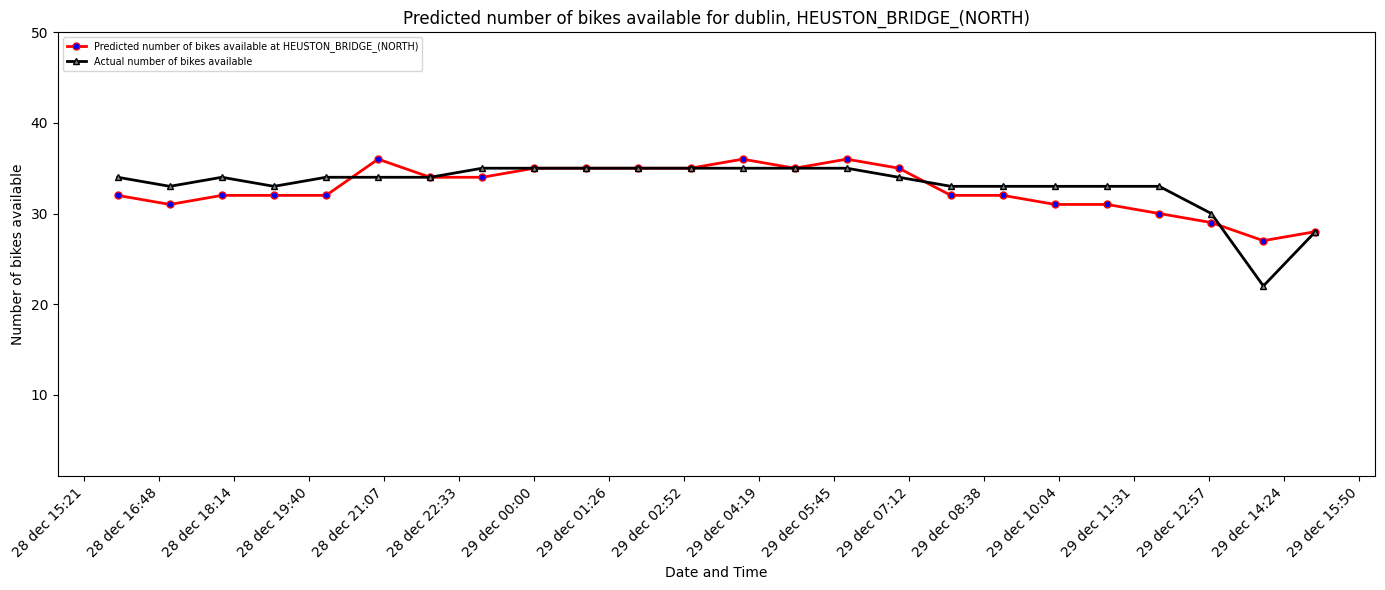

In [95]:
file_path = "docs/bike_availability_hindcast_1day.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, hindcast_df, file_path, hindcast=True)
plt.show()